In [15]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pickle
import glob


def load_model(model_path):
    """Load the trained model."""
    print(f"Loading model from {model_path}...")
    model = keras.models.load_model(model_path, compile=False)
    model.summary()
    return model

def preprocess_data(input_file, vars_mli):
    """Preprocess input data for prediction."""
    ds = xr.open_dataset(input_file, engine="netcdf4")
    ds = ds[vars_mli]
    ds["state_t"] = ds["state_t"][0]
    ds["state_q0001"] = ds["state_q0001"][0]
    return ds.stack({"batch": {"ncol"}}).to_stacked_array(
        "mlvar", sample_dims=["batch"], name="mli"
    ).values

def make_predictions(input_file, model, vars_mli, vars_mlo, output_dir):
    """Make predictions and save results."""
    print(f"Processing input file: {input_file}")
    input_data = preprocess_data(input_file, vars_mli)
    predictions = model.predict(input_data)
    return predictions, input_data, vars_mlo

    # Load ground truth
    ds_ground_truth = xr.open_dataset(
        input_file.replace(".mli.", ".mlo."), engine="netcdf4"
    )
    ds_ground_truth = ds_ground_truth[vars_mlo].stack({"batch": {"lev"}}).to_stacked_array(
        "mlvar", sample_dims=["batch"], name="mlo"
    ).values

    # Save predictions and ground truth for comparison
    output_file = os.path.join(output_dir, "predictions_vs_ground_truth.nc")
    print(f"Saving predictions and ground truth to {output_file}")
    xr.Dataset(
        {
            "predictions": (["batch", "mlvar"], predictions_rescaled),
            "ground_truth": (["batch", "mlvar"], ds_ground_truth),
        }
    ).to_netcdf(output_file)

    return predictions_rescaled, ds_ground_truth

def plot_comparison(predictions, ground_truth, vars_mlo, output_dir):
    """Visualize predictions vs ground truth for key variables."""
    for i, var in enumerate(vars_mlo):
        plt.figure(figsize=(12, 8))
        plt.plot(ground_truth[:, i], label=f"Ground Truth ({var})", alpha=0.7)
        plt.plot(predictions[:, i], label=f"Predictions ({var})", alpha=0.7)
        plt.title(f"Comparison: {var}", fontsize=16)
        plt.xlabel("Batch", fontsize=14)
        plt.ylabel(var, fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.6)

        output_file = os.path.join(output_dir, f"comparison_{var}.png")
        plt.savefig(output_file)
        plt.close()
        print(f"Saved comparison plot: {output_file}")
        

In [18]:
with open("file_list.pkl", "rb") as f:
    all_files = pickle.load(f)
    print("Loaded file list from file_list.pkl.")

data_file_path = "/home/clarkkam/AIFS/ClimSim/climate-physicsML/data/climsim_lowres_0001-02/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0001-02/" 
all_files = glob.glob(os.path.join(data_file_path, '*MMF.mli*.nc'))

Loaded file list from file_list.pkl.


In [19]:
all_files[0]


'/home/clarkkam/AIFS/ClimSim/climate-physicsML/data/climsim_lowres_0001-02/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0001-02/E3SM-MMF.mli.0001-02-15-33600.nc'

In [42]:
files = [0, 500, 1000, 1500, 2000, -1]

In [44]:
input_files = [all_files[i] for i in files]
ground_truths = [file.replace(".mli.", ".mlo.") for file in input_files]

['/home/clarkkam/AIFS/ClimSim/climate-physicsML/data/climsim_lowres_0001-02/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0001-02/E3SM-MMF.mli.0001-02-15-33600.nc', '/home/clarkkam/AIFS/ClimSim/climate-physicsML/data/climsim_lowres_0001-02/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0001-02/E3SM-MMF.mli.0001-02-17-01200.nc', '/home/clarkkam/AIFS/ClimSim/climate-physicsML/data/climsim_lowres_0001-02/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0001-02/E3SM-MMF.mli.0001-02-26-81600.nc', '/home/clarkkam/AIFS/ClimSim/climate-physicsML/data/climsim_lowres_0001-02/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0001-02/E3SM-MMF.mli.0001-02-14-12000.nc', '/home/clarkkam/AIFS/ClimSim/climate-physicsML/data/climsim_lowres_0001-02/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0001-02

In [45]:
# Define paths
# input_file = all_files[0]
# groundtruth_file = input_file.replace(".mli.", ".mlo.")  # Replace with your .mlo file

model_path = "/home/clarkkam/AIFS/ClimSim/climate-physicsML/data/DataFraction0.1/output_batch_size_128_learning_rate_0.00001_lambda_0.0/results_0.1/best_model_lambda_0.0_datafrac_0.1_epoch_1.keras"
output_dir = "/home/clarkkam/AIFS/ClimSim/climate-physicsML/final_combined_loss_model/out_model_figures"  # Replace with your output directory

# Variables for input (mli) and output (mlo)
vars_mli = [
    "state_t", "state_q0001", "state_ps", "pbuf_SOLIN", "pbuf_LHFLX", "pbuf_SHFLX", "cam_in_LWUP"
]

vars_mlo = ['ptend_t','ptend_q0001','cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC','cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD']

In [35]:
# Load the trained model
model = load_model(model_path)

Loading model from /home/clarkkam/AIFS/ClimSim/climate-physicsML/data/DataFraction0.1/output_batch_size_128_learning_rate_0.00001_lambda_0.0/results_0.1/best_model_lambda_0.0_datafrac_0.1_epoch_1.keras...


Model: "Emulator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 7)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 768)       │      6,144 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 640)       │    492,160 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    328,192 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 640)       │    328,320 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 640)       │    410,240 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 10)        │      6,410 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 2)         │         22 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 8)         │         88 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10)        │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,571,576 (6.00 MB)

 Trainable params: 1,571,576 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
preds = []
for file in input_files:
    predictions, input_data, vars_mlo = make_predictions(file, model, vars_mli, vars_mlo, output_dir)
    name = file[len(data_file_path):]
    preds.append((predictions, name))

Processing input file: /home/clarkkam/AIFS/ClimSim/climate-physicsML/data/climsim_lowres_0001-02/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0001-02/E3SM-MMF.mli.0001-02-15-33600.nc
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Processing input file: /home/clarkkam/AIFS/ClimSim/climate-physicsML/data/climsim_lowres_0001-02/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0001-02/E3SM-MMF.mli.0001-02-17-01200.nc
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Processing input file: /home/clarkkam/AIFS/ClimSim/climate-physicsML/data/climsim_lowres_0001-02/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0001-02/E3SM-MMF.mli.0001-02-26-81600.nc
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Processing input file: /home/clarkkam/AIFS/ClimSim/climate-physicsML/data/climsim_lowres_0001-02/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0001-02/E3SM-MMF.mli.0001-02-14-12000.nc
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Processing input file: /home/clarkkam/AIFS/ClimSim/climate-physicsML/data/climsim_lowres_0001-02/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0001-02/E3SM-

In [51]:
preds[0][0].shape

(384, 10)

In [38]:
fn_grid = '/home/clarkkam/AIFS/ClimSim/grid_info/ClimSim_low-res_grid-info.nc'
ds_grid = xr.open_dataset(fn_grid, engine='netcdf4')

In [29]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

def plot_contour_map(lat, lon, values, cmap='viridis', vmin=None, vmax=None, clev=11, title='', save_path=None):
    """
    Plot a contour map with latitude, longitude, and values on a global map.

    Parameters:
    - lat: Array-like, latitude values.
    - lon: Array-like, longitude values.
    - values: Array-like, data values corresponding to lat/lon.
    - cmap: Colormap for the plot. Default is 'viridis'.
    - vmin: Minimum value for the colormap. Default is min(values).
    - vmax: Maximum value for the colormap. Default is max(values).
    - clev: Number of contour levels. Default is 11.
    - title: Title of the plot.
    - save_path: Path to save the plot. If None, the plot is shown interactively.
    """
    # Set up the plot
    fig, ax = plt.subplots(
        subplot_kw={'projection': ccrs.PlateCarree()},
        figsize=(10, 5)
    )
    
    # Set global map features
    ax.set_global()
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Handle colormap limits and contour levels
    vmin = vmin if vmin is not None else np.min(values)
    vmax = vmax if vmax is not None else np.max(values)
    clevels = np.linspace(vmin, vmax, clev)

    # Plot the contour map
    contour = ax.tricontourf(
        lon, lat, values, levels=clevels, cmap=cmap, transform=ccrs.PlateCarree()
    )

    # Add colorbar
    cbar = fig.colorbar(contour, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
    cbar.set_label('Value')

    # Add title
    ax.set_title(title, fontsize=14)

    # Save or show the plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()


In [30]:
vars_mlo

['ptend_t',
 'ptend_q0001',
 'cam_out_NETSW',
 'cam_out_FLWDS',
 'cam_out_PRECSC',
 'cam_out_PRECC',
 'cam_out_SOLS',
 'cam_out_SOLL',
 'cam_out_SOLSD',
 'cam_out_SOLLD']

In [52]:
ptend_t_index = 0
preds[0][0][:,ptend_t_index]

array([-116.61555 , -121.03224 , -115.18785 , -122.26812 , -124.41685 ,
       -126.86222 , -126.731   , -130.27399 , -129.8889  , -134.08409 ,
       -131.70892 , -132.41257 , -135.89404 , -135.25027 , -131.75839 ,
       -134.8087  , -114.37294 , -122.11355 , -115.02471 , -121.61209 ,
       -126.60645 , -130.25876 , -126.407936, -130.2852  , -130.84785 ,
       -132.33878 , -131.97655 , -133.85762 , -129.44095 , -135.352   ,
       -132.88089 , -134.81795 , -116.55826 , -121.507866, -116.107025,
       -120.18869 , -125.52315 , -129.57494 , -122.42672 , -125.35578 ,
       -132.35805 , -133.84184 , -127.65913 , -128.75945 , -133.75487 ,
       -134.80382 , -131.59816 , -132.1892  , -113.85844 , -117.99453 ,
       -111.48458 , -114.29362 , -120.516975, -121.19122 , -116.85684 ,
       -118.72744 , -123.08663 , -126.318115, -121.38341 , -125.14648 ,
       -128.16837 , -130.1658  , -126.64154 , -124.83043 , -134.22926 ,
       -133.04208 , -137.45854 , -135.67163 , -130.7416  , -127.

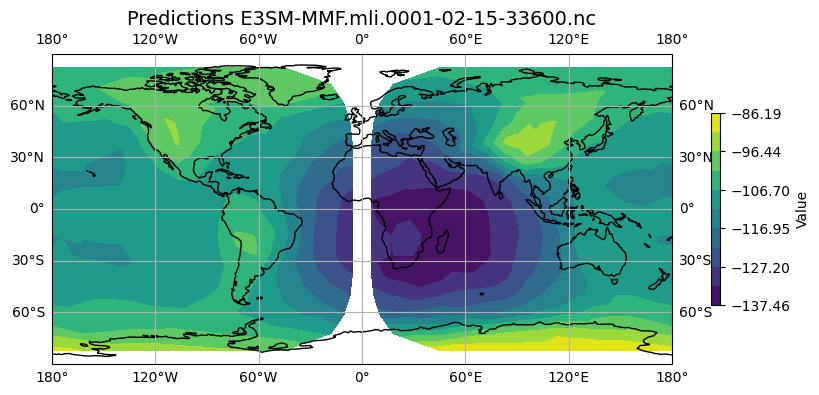

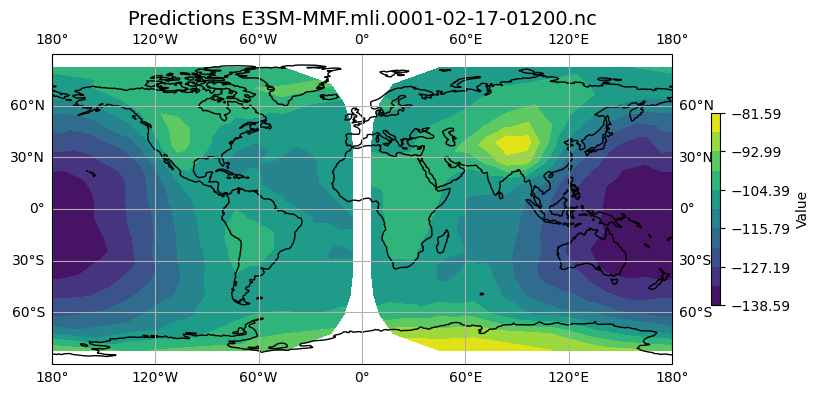

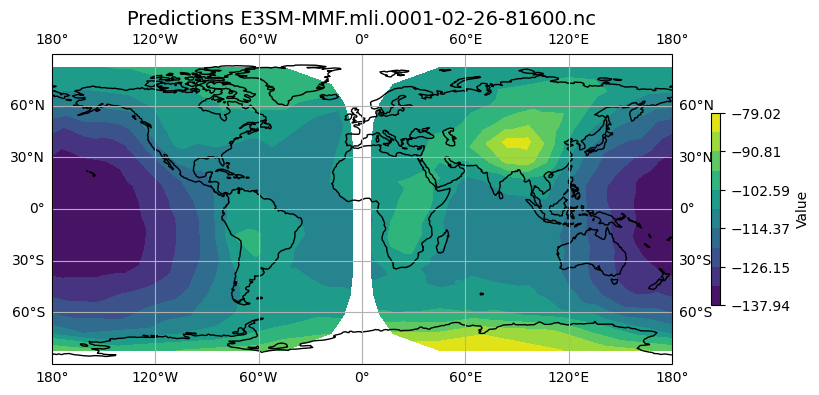

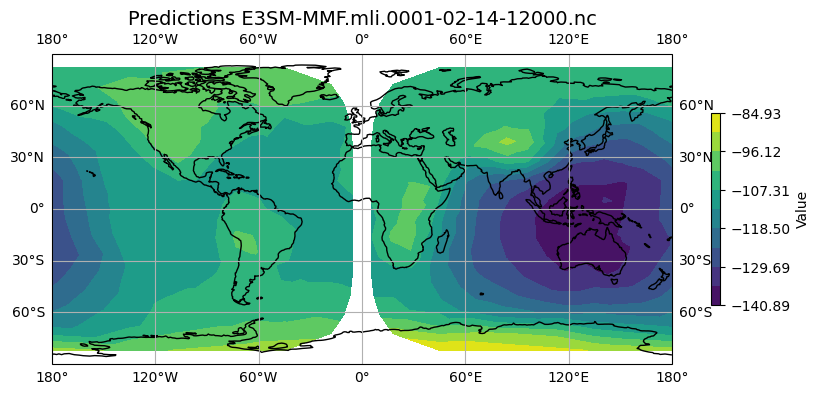

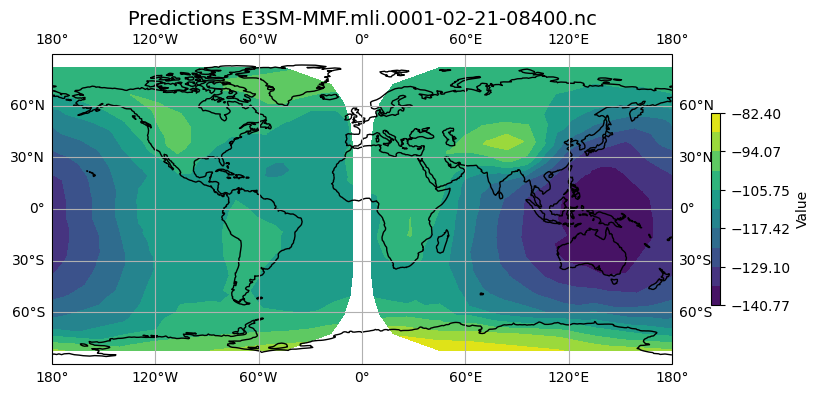

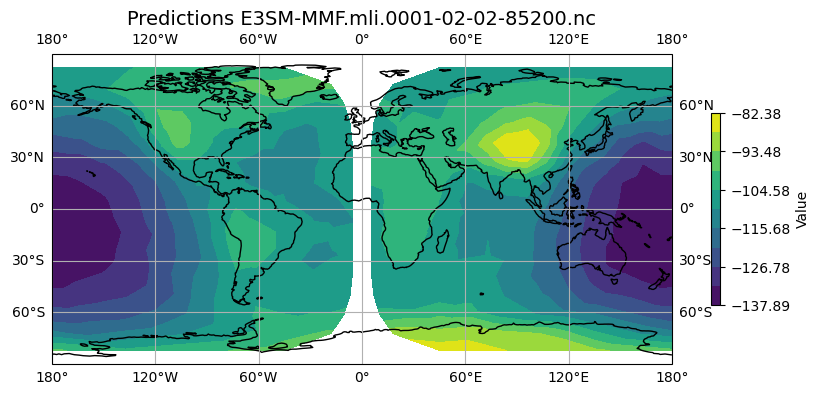

In [59]:
for pred in preds:
    plot_contour_map(ds_grid['lat'], ds_grid['lon'], pred[0][:,ptend_t_index], title=f"Predictions {pred[1]}")

# Looking at a single day:

In [73]:
all_files = glob.glob(os.path.join(data_file_path, '*MMF.mli.0001-02-02*.nc'))
all_files = sorted(all_files)
print(len(all_files))


72


In [70]:
num_files = 4
total_files = len(all_files)
step = total_files // num_files
file_indices = [i * step for i in range(num_files)]
file_indices

[0, 18, 36, 54]

In [71]:
input_files = [all_files[i] for i in file_indices]
ground_truths = [file.replace(".mli.", ".mlo.") for file in input_files]
preds = []
for file in input_files:
    predictions, input_data, vars_mlo = make_predictions(file, model, vars_mli, vars_mlo, output_dir)
    name = file[len(data_file_path):]
    preds.append((predictions, name))

Processing input file: /home/clarkkam/AIFS/ClimSim/climate-physicsML/data/climsim_lowres_0001-02/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0001-02/E3SM-MMF.mli.0001-02-02-00000.nc


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Processing input file: /home/clarkkam/AIFS/ClimSim/climate-physicsML/data/climsim_lowres_0001-02/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0001-02/E3SM-MMF.mli.0001-02-02-21600.nc
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Processing input file: /home/clarkkam/AIFS/ClimSim/climate-physicsML/data/climsim_lowres_0001-02/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0001-02/E3SM-MMF.mli.0001-02-02-43200.nc
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Processing input file: /home/clarkkam/AIFS/ClimSim/climate-physicsML/data/climsim_lowres_0001-02/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0001-02/E3SM-MMF.mli.0001-02-02-64800.nc
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [79]:
ground_truth_data = []
for file in ground_truths:
    dso = xr.open_dataset(file, engine="netcdf4")
    ds = xr.open_dataset(file.replace('.mlo.', '.mli.'), engine='netcdf4')
    ds = ds[vars_mli]
    ds["state_t"] = ds["state_t"][0]
    ds["state_q0001"] = ds["state_q0001"][0]

    dso['ptend_t'] = (dso['state_t'] - ds['state_t']) / 1200  # T tendency [K/s]
    dso['ptend_q0001'] = (dso['state_q0001'] - ds['state_q0001']) / 1200  # Q tendency [kg/kg/s]
    dso = dso[vars_mlo]
    dso['ptend_t'] = dso['ptend_t'][0]
    dso['ptend_q0001'] = dso['ptend_q0001'][0]
    dso = dso.stack({"batch": {"ncol"}}).to_stacked_array(
        "mlvar", sample_dims=["batch"], name="mli"
    ).values 
    ground_truth_data.append(dso)
ground_truth_data[0][:,ptend_t_index]

array([-1.83824319e-05, -1.77474181e-05, -1.40125407e-05, -2.05624814e-05,
       -2.03392097e-05, -2.12117757e-05, -1.51369736e-05, -1.71236628e-05,
       -1.86582193e-05, -1.62394705e-05, -1.45431976e-05, -1.33427027e-05,
       -1.57919904e-05, -1.70896836e-05, -1.53685043e-05, -1.77402632e-05,
       -8.78833034e-06, -1.81473774e-05, -6.95166072e-06, -1.10598315e-05,
       -1.58711820e-05, -9.30366601e-06, -1.51266480e-05, -4.87024814e-06,
       -8.82820226e-06, -8.06015505e-06,  3.30417178e-06,  3.23619586e-06,
       -8.99100245e-06, -1.04989550e-05,  9.33092791e-08, -3.53777905e-06,
       -1.09154772e-05, -1.83297215e-05, -1.11717106e-05, -1.27972309e-05,
       -1.55484688e-05,  3.94643486e-06, -4.51770018e-06, -7.57291972e-07,
        3.18716511e-06, -3.21790366e-06, -9.11222579e-06, -1.37607775e-05,
       -2.07268094e-06,  1.53240016e-06, -1.04868193e-05, -2.17749791e-06,
       -1.61219218e-05, -1.24905374e-05, -2.25074159e-05, -2.02825886e-05,
       -8.25789601e-06, -

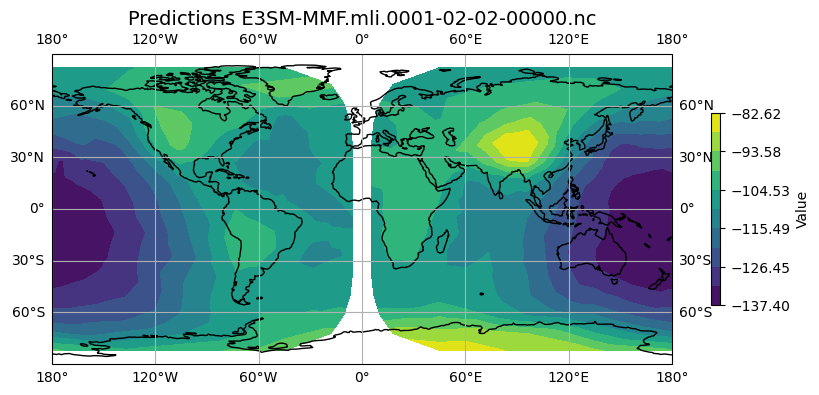

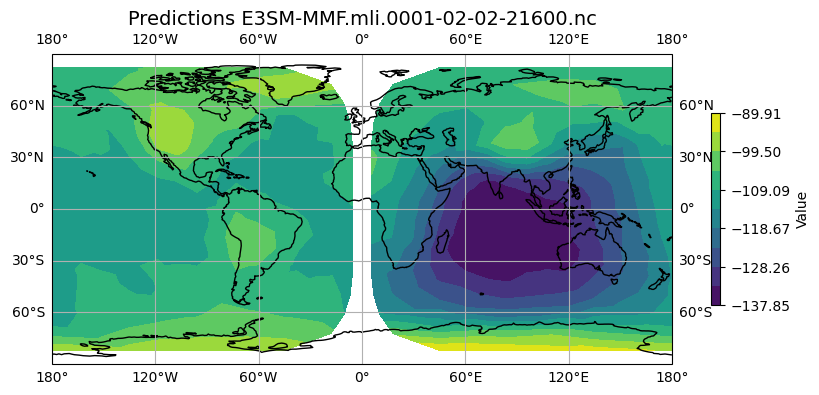

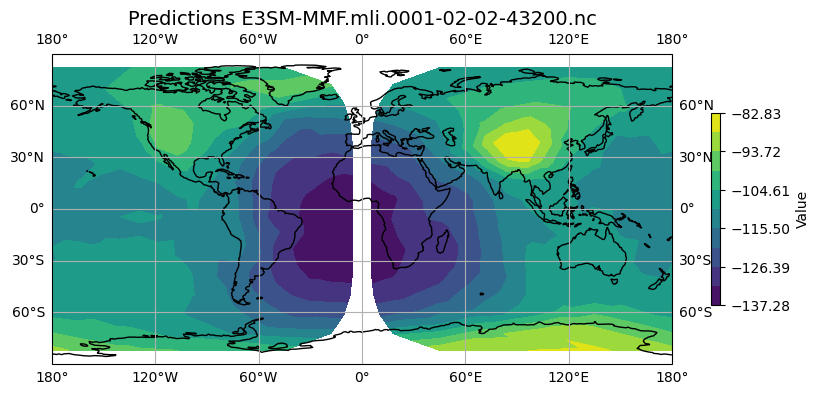

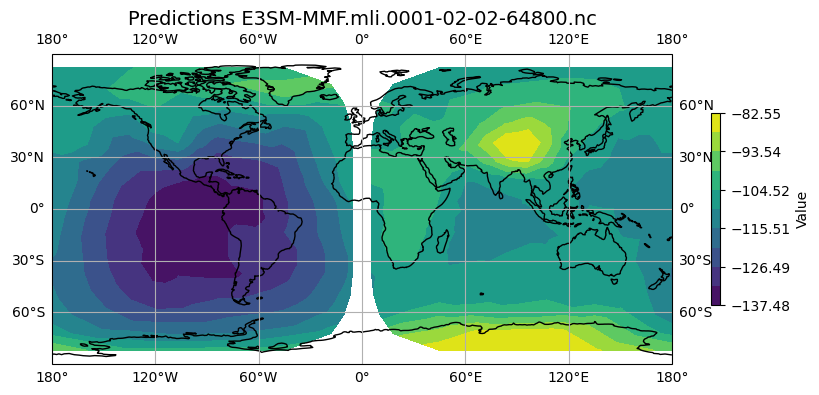

In [72]:
for pred in preds:
    plot_contour_map(ds_grid['lat'], ds_grid['lon'], pred[0][:,ptend_t_index], title=f"Predictions {pred[1]}")

# Looking at error now:

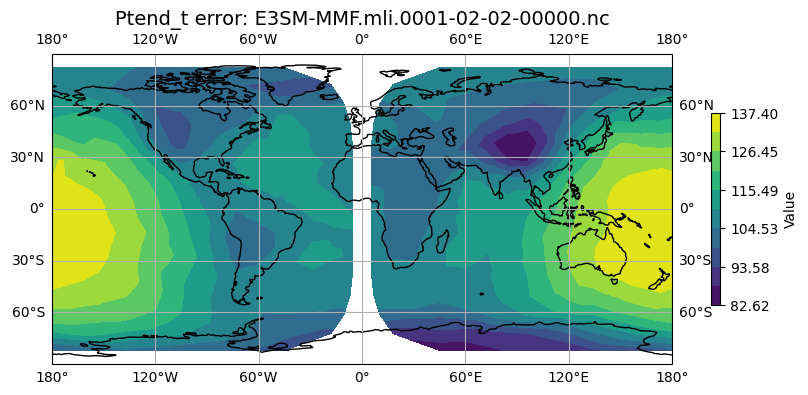

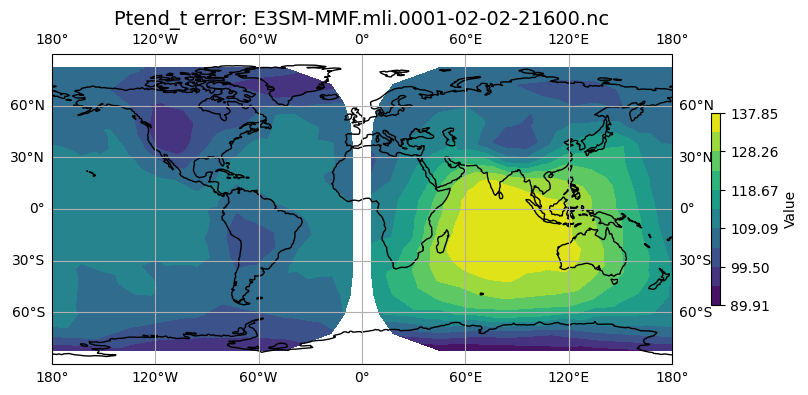

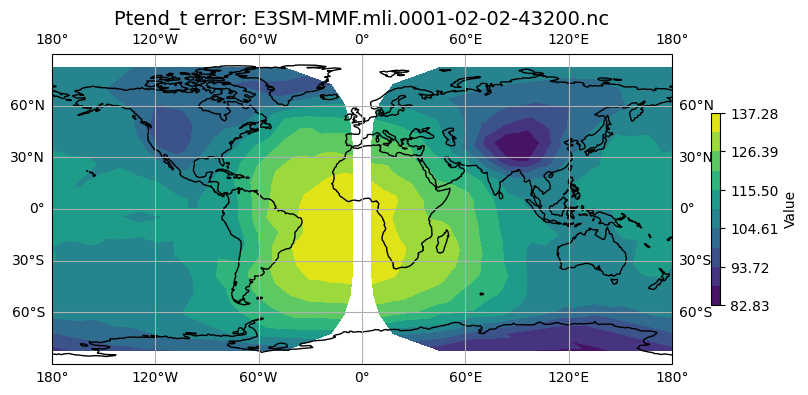

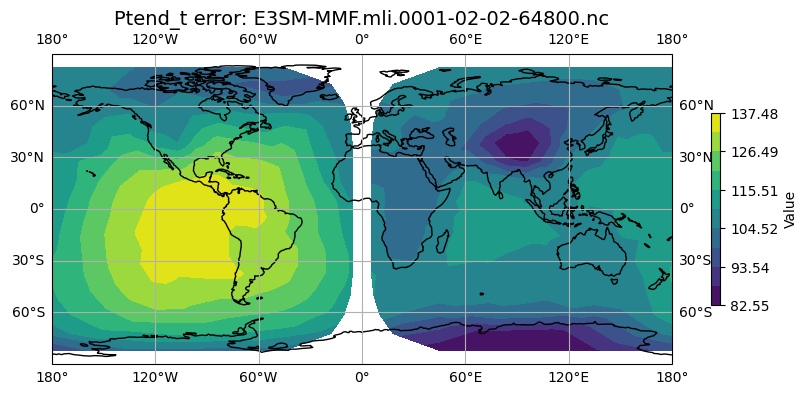

In [81]:
for index, pred in enumerate(preds):
    plot_contour_map(ds_grid['lat'], ds_grid['lon'], abs(pred[0][:,ptend_t_index] - ground_truth_data[index][:,ptend_t_index]), title=f"Ptend_t error: {pred[1]}")